## PREDICTING FINANCIAL WELL-BEING OF SMALL BUSINESSES

Across Southern Africa, small and medium-sized enterprises (SMEs) are vital to employment, innovation, and economic growth, yet many remain financially fragile and excluded from formal financial systems. Limited access to credit, unstable cash flow, and exposure to shocks such as illness or climate events make them vulnerable. Traditional measures like revenue or profit do not capture an SME’s true financial well-being. To support SMEs more effectively, there is a need for a holistic measure that reflects resilience, savings habits, and access to finance.

This challenge introduces a data-driven Financial Health Index (FHI) for SMEs - a composite measure that classifies businesses into Low, Medium, or High financial health across four key dimensions: 
- savings and assets
- debt and repayment ability
- resilience to shocks
- access to credit and financial services. 

Derived from survey and business data, the FHI offers a more complete picture of financial stability and inclusion.

### Data Inspection

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [138]:
train_data = pd.read_csv('Train.csv')
test_data = pd.read_csv('Test.csv')

In [140]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9618 entries, 0 to 9617
Data columns (total 39 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   ID                                                                9618 non-null   object 
 1   country                                                           9618 non-null   object 
 2   owner_age                                                         9618 non-null   float64
 3   attitude_stable_business_environment                              9616 non-null   object 
 4   attitude_worried_shutdown                                         9616 non-null   object 
 5   compliance_income_tax                                             9614 non-null   object 
 6   perception_insurance_doesnt_cover_losses                          9613 non-null   object 
 7   perception_cannot_afford_insuranc

In [116]:
test_data.head()

,ID,country,owner_age,attitude_stable_business_environment,attitude_worried_shutdown,compliance_income_tax,perception_insurance_doesnt_cover_losses,perception_cannot_afford_insurance,personal_income,business_expenses,...,has_loan_account,has_internet_banking,has_debit_card,future_risk_theft_stock,business_age_months,medical_insurance,funeral_insurance,motivation_make_more_money,uses_friends_family_savings,uses_informal_lender
0,ID_5EGLKX,zimbabwe,50.0,No,No,No,No,Yes,100.0,3600.0,...,NaN,NaN,NaN,No,8.0,Never had,Never had,NaN,NaN,NaN
1,ID_4AI7RE,lesotho,36.0,Yes,Yes,No,Yes,Yes,900.0,400.0,...,NaN,NaN,NaN,Yes,NaN,NaN,NaN,Yes,Used to have but don't have now,Used to have but don't have now
2,ID_V9OB3M,lesotho,25.0,Don’t know or N/A,No,No,Don't know,Don't know,5250.0,350.0,...,Used to have but don't have now,Have now,Have now,Yes,NaN,NaN,NaN,No,Never had,Used to have but don't have now
3,ID_6OI9DI,malawi,25.0,Don’t know or N/A,Yes,No,No,Yes,485000.0,10000.0,...,Never had,Never had,Never had,Yes,NaN,NaN,NaN,Yes,Have now,Never had
4,ID_H2TN8B,lesotho,47.0,No,Yes,No,Don't know,Don't know,97.0,500.0,...,Used to have but don't have now,Have now,Have now,Yes,NaN,NaN,NaN,Yes,Used to have but don't have now,Used to have but don't have now


In [92]:
print(train_data.shape)
print(test_data.shape)

(9618, 39)
(2405, 38)


### Data Processing


In [9]:
#Define X and y 
X = train_data.drop(columns=['Target', 'ID'])
y = train_data['Target']


# Change object data types to categorical
def change_object_to_cat(df):
  # changes objects columns to category and returns dataframe and list

  df = df.copy()
  list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
  for str_obj_col in list_str_obj_cols:
      df[str_obj_col] = df[str_obj_col].astype("category")

  return df,list_str_obj_cols
X, cat_list = change_object_to_cat(X)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9618 entries, 0 to 9617
Data columns (total 37 columns):
 #   Column                                                            Non-Null Count  Dtype   
---  ------                                                            --------------  -----   
 0   country                                                           9618 non-null   category
 1   owner_age                                                         9618 non-null   float64 
 2   attitude_stable_business_environment                              9616 non-null   category
 3   attitude_worried_shutdown                                         9616 non-null   category
 4   compliance_income_tax                                             9614 non-null   category
 5   perception_insurance_doesnt_cover_losses                          9613 non-null   category
 6   perception_cannot_afford_insurance                                9613 non-null   category
 7   personal_income         

Now, there are only categorical and float data types

## FEATURE ENGINEERING

### 1. Savings and Assets
This dimension represents the liquidity and collateral of the SME.

Direct Effect: High levels of savings allow a business to self-fund expansion (buying new inventory or machinery) without waiting for a loan. Physical assets (vehicles, equipment) increase productivity.

Modeling Insight: In your data, features like business_turnover and keeps_financial_records are often proxies for this. A business that saves is statistically less likely to collapse during a "slow month."

#### Create profitability and margin features

In [ ]:


def create_savings_assets_features_v2(df):
    df = df.copy()

    # 1. Handle Numerical NaNs BEFORE calculation
    # We use 0 for turnover/expenses so the ratio calculation doesn't fail
    temp_turnover = df['business_turnover'].fillna(0)
    temp_expenses = df['business_expenses'].fillna(0)

    # 2. Profit & Margin with CLIPPING
    # Clipping ensures one failing business doesn't have the weight of 1,000 others
    profit = temp_turnover - temp_expenses
    df['Profit_Margin'] = (profit / (temp_turnover + 1)).clip(-2, 1)

    # 3. Robust Mapping for Yes/No
    # This handles "Don't know" or Missing values as 0 (Neutral/No)
    cols_to_map = [
        'keeps_financial_records', 'has_debit_card', 
        'has_credit_card', 'offers_credit_to_customers', 
        'uses_friends_family_savings'
    ]
    
    for col in cols_to_map:
        df[col] = df[col].astype(str).str.strip().map({'Yes': 1, 'No': 0}).fillna(0)

    # 4. Component Scores
    df['Financial_discipline_score'] = (
        df['keeps_financial_records'] + 
        df['has_debit_card'] + 
        df['has_credit_card']
    ) / 3.0 # Normalize to 0-1 range

    df['formal_savings_indicator'] = 1 - df['uses_friends_family_savings']

    # 5. The Final Index (No NaNs possible here)
    df['savings_assets_index'] = (
        0.4 * df['Profit_Margin'] +
        0.3 * df['Financial_discipline_score'] +
        0.2 * df['formal_savings_indicator'] +
        0.1 * df['offers_credit_to_customers']
    )

    return df

# Apply to your data
train_data = create_savings_assets_features_v2(train_data)
test_data = create_savings_assets_features_v2(test_data)

Apply to train and val sets

### Analyze relationship with Traget

In [142]:
train_data.groupby('Target')['savings_assets_index'].mean()

Target
High      0.410537
Low       0.346701
Medium    0.357550
Name: savings_assets_index, dtype: float64

The 'savings_assets_index' behaves like this:
- Low FHI : strongly negative
- Medium FHI: moderately positive
- High FHI: highest positive

Meaning as savings and assets strength increases, financial health index increases, economically the feature aligns with FHI. Low class of -1.91 suggests that Low FHI businesses have; poor profit margins, weak financial discipline, informal savings reliance and possibly high expense ratios.

Let us employ a statistical test to test the significant difference across groups

In [ ]:
from scipy.stats import f_oneway

low = train_data[train_data['Target']== 'Low']['savings_assets_index']
medium = train_data[train_data['Target']== 'Medium']['savings_assets_index']
high = train_data[train_data['Target']== 'High']['savings_assets_index']

f_stat, p_value = f_oneway(
    low, 
    medium, 
    high
)

print("F-stat:", f_stat)
print("P-value:", p_value)




F-stat: 14.33493033224489
P-value: 6.076900427654865e-07


In [145]:
np.isinf(train_data['savings_assets_index']).sum()

0

The savings_assets_index is now statstically significant feature that efectively distinguishes between Low, medium and high financial health.


In [144]:
print(low.var())
print(medium.var())
print(high.var())


0.07176785320316434
0.053517661568174536
0.04522023918358566


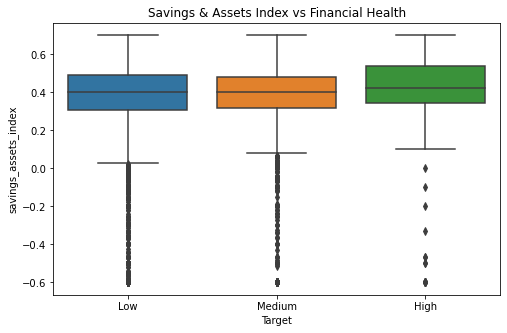

In [146]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Target', y='savings_assets_index', data=train_data)
plt.title("Savings & Assets Index vs Financial Health")
plt.show()

### 2. Debt and Repayment ability

- This dimension is about the 'cost of capital' and whether the business is drowning in debt or using it to grow. Based on the dataset, we have key indicators like has loan account, uses informal lender, business expenses and current problem cashflow

- The strategy identifies good vs bad debt. 

*Repayment ability*: High expenses relative to turnover(without a loan) suggest poor efficiency. High expenses with a loan suggest a heavy repayment burden.

*Formal vs. Informal*: Informal lenders often have much higher interest rates, which directly hurts the Financial Health Index(FHI)

*Cash Flow*: A business that reports cash flow problems is statistically more likely to default on debt.

### Train-test split the data 

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=train_data[['country', 'Target']]
)

### Processing

In [12]:

# 1. Identify your columns
num_cols = X_train.select_dtypes(include=['float64']).columns
cat_cols = X_train.select_dtypes(include=['category']).columns

# 2. Define the Numerical Transformer
# Median is safer for financial data; Scaling is essential for most models
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 3. Define the Categorical Transformer
# handle_unknown='ignore' prevents the model from crashing if the test set 
# has a category the training set never saw.
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)) 
])

# 4. Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

# 5. Fit and Transform X_train
# We "fit" only on train to avoid data leakage
X_train_processed = preprocessor.fit_transform(X_train)

# 6. Transform X_val
# We only "transform" the test set using the logic learned from train
X_val_processed = preprocessor.transform(X_val)

print(f"Original shape: {X_train.shape}")
print(f"Processed shape: {X_train_processed.shape}")

Original shape: (7694, 37)
Processed shape: (7694, 155)
